# On backported updates

In [1]:
import pandas
import numpy as np
import matplotlib
import seaborn

from scipy.stats import mannwhitneyu
from cliffsDelta import cliffsDelta

from IPython.display import display

%matplotlib inline

In [2]:
FIG_SIZE = (8, 3)
FIG_SIZE_WIDE = (8, 2.5)

ECOSYSTEMS = ['Cargo', 'NPM', 'Packagist', 'Rubygems']
DATE_RANGE = pandas.to_datetime('2015-01-01'), pandas.to_datetime('2020-01-01')
CENSOR_DATE = pandas.to_datetime('2020-01-12')

PALETTE = seaborn.color_palette()
PAL_REL = np.take(seaborn.color_palette('muted'), [3, 8, 2, 0], axis=0)
COLORS = {e: PALETTE[i] for i, e in enumerate(ECOSYSTEMS)}

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
matplotlib.rcParams['legend.framealpha'] = 1
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

SAVEFIG = False

def _savefig(fig, name):
    import os
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )
    
savefig = _savefig if SAVEFIG else lambda x, y: None

# Datasets

## Load data

In [3]:
df_required = dict()
df_dependents = dict()

for ecosystem in ECOSYSTEMS:
    print('Loading', ecosystem)
    print('.. required packages')
    df_required[ecosystem] = (
        pandas.read_csv(
            '../data/{}-required.csv.gz'.format(ecosystem),
            parse_dates=['date'],
            infer_datetime_format=True,
        )
    )
    
    print('.. dependent packages')
    df_dependents[ecosystem] = (
        pandas.read_csv(
            '../data/{}-dependents.csv.gz'.format(ecosystem),
        )
    )
    
print('Done!')

Loading Cargo
.. required packages
.. dependent packages
Loading NPM
.. required packages
.. dependent packages
Loading Packagist
.. required packages
.. dependent packages
Loading Rubygems
.. required packages
.. dependent packages
Done!


## Data cleaning

We know there are cases in which many releases of a package are imported at the same time, or in a non-revelant order. 
Such cases are problematic, since the corresponding updates are likely to be wrongly considered as backports. 

To mitigate this, we remove each package:
 - (1) for which the chronological order of its major releases does not follow the version order;
 - (2) for which the first chronological release is not the very first release;
 - (3) for which a release preceedes the release date of its corresponding major.

In [4]:
data = pandas.concat([
    df_required[ecosystem]
    [lambda d: d['kind'].isin(['major', 'initial'])]
    [['package', 'rank', 'rank_date']]
    .sort_values('rank')
    # (1) and (2)
    .groupby('package', sort=False, as_index=False)
    .agg({
        'rank_date': lambda s: s.rank().is_monotonic,
    })
    .query('not rank_date')
    [['package']]
    .append(
        # (3)
        df_required[ecosystem]
        [lambda d: d['package'].isin(
            df_required[ecosystem]
            .sort_values('rank_date')
            .groupby(['package', 'major'], sort=False, as_index=False)
            .first()
            .query('kind not in ["major", "initial"]')
            .package    
        )]
        [['package']]
        .drop_duplicates()
    )
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'package']]
    for ecosystem in ECOSYSTEMS]
)

In [5]:
(
    data
    .groupby('ecosystem')
    .count()
)

,package
ecosystem,
Cargo,6
NPM,380
Packagist,96
Rubygems,81


Let's have a look at some example. This package got its 2.y.z releases before its 1.y.z ones. 

In [6]:
df_required['Cargo'].query('package == "llvm-sys"').sort_values('date')[['version', 'rank', 'date']]

,version,rank,date
10931,0.2.0,3,2015-08-18 18:07:20
10930,0.1.4,2,2015-08-18 18:13:45
10929,0.1.3,1,2015-08-18 18:20:27
10932,0.2.1,4,2015-09-09 20:22:14
10933,0.2.2,5,2016-02-21 23:02:45
...,...,...,...
11004,60.4.1,76,2019-07-12 11:41:24
10994,50.3.1,66,2019-07-12 11:43:42
10984,40.3.1,56,2019-07-12 11:45:58
11014,80.1.2,86,2019-12-04 06:57:19


Let's remove these packages, and the related dependents.

In [7]:
for ecosystem in ECOSYSTEMS:
    packages = data[lambda d: d['ecosystem'] == ecosystem].package
    df_required[ecosystem] = df_required[ecosystem][lambda d: ~d['package'].isin(packages)]
    df_dependents[ecosystem] = df_dependents[ecosystem][lambda d: ~d['target'].isin(packages)]

## Data overview

In [8]:
data = pandas.DataFrame(index=['required', 'releases', 'dependents', 'dependencies'], columns=ECOSYSTEMS)

for ecosystem in ECOSYSTEMS:
    data.at['required', ecosystem] = len(df_required[ecosystem].drop_duplicates('package'))
    data.at['releases', ecosystem] = len(df_required[ecosystem])
    data.at['dependents', ecosystem] = len(df_dependents[ecosystem].drop_duplicates('source'))
    data.at['dependencies', ecosystem] = len(df_dependents[ecosystem])
    
data

,Cargo,NPM,Packagist,Rubygems
required,1185,15281,2247,652
releases,26185,570676,100870,35264
dependents,13143,242618,35488,7915
dependencies,59814,1021843,89667,15066


In [9]:
data.T[['required', 'releases', 'dependents', 'dependencies']].sum()

required          19365.0
releases         732995.0
dependents       299164.0
dependencies    1186390.0
dtype: float64

Our dependency constraint parsers were able to cope with the large majority of dependency constraints. However, some of them could not be parsed. Let's quantify this. Since the analyses that rely on this preparatory parsing step focus on the latest snapshot of each ecosystem, we only consider this snapshot to quantify this phenomenon.

In [10]:
(
    pandas.concat([
        df_dependents[ecosystem]
        .sort_values('rank')
        .drop_duplicates('source', keep='last')
        .assign(ecosystem=ecosystem)
        for ecosystem in ECOSYSTEMS], 
        axis=0
    )
    .pivot_table(index='ecosystem', columns=['c_empty'], values='target', aggfunc='count', margins=True)
    .fillna(0)
    .assign(prop=lambda d: d[True] / d['All'])
)

c_empty,False,True,All,prop
ecosystem,,,,
Cargo,13143.0,0.0,13143,0.000000
NPM,240949.0,1669.0,242618,0.006879
Packagist,34624.0,864.0,35488,0.024346
Rubygems,7400.0,515.0,7915,0.065066
All,296116.0,3048.0,299164,0.010188


# On the need to backport updates to previous major

## Permissivity of dependency constraints

We look at how permissive dependency constraints are, this is, whether they accept patches, minor or major releases. Since we know from previous work that such permissiveness depends on whether the target package is 0.y.z or >=1.0.0, we distinguish these two cases. 

Let's first quantify the number of targets for each category.

In [11]:
pandas.concat([
    df_dependents[ecosystem]
    .groupby('c_dev', as_index=False)
    [['target']]
    .count()
    .assign(prop=lambda d: d['target'] / d['target'].sum())
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS], axis=0
).set_index(['ecosystem', 'c_dev'])

target      prop
ecosystem c_dev                  
Cargo     False   21455  0.358695
          True    38359  0.641305
NPM       False  919629  0.899971
          True   102214  0.100029
Packagist False   86410  0.963677
          True     3257  0.036323
Rubygems  False   12555  0.833333
          True     2511  0.166667

In [12]:
data = pandas.concat([
    df_dependents[ecosystem]
    .sort_values('rank')
    .drop_duplicates(['source', 'target'], keep='last')
    .assign(
        n=1,
        # Correct values, as patch superseeded by minor superseeded by major
        patch=lambda d: d['c_patch'] & ~d['c_minor'] & ~d['c_major'],
        minor=lambda d: d['c_minor'] & ~d['c_major'],
        major=lambda d: d['c_major'],
    )
    .pivot_table(index='c_dev', values=['n', 'major', 'minor', 'patch'], aggfunc='sum')
    .apply(lambda s: s / s.n, axis=1)
    .drop(columns=['n'])
    .reset_index()
    .rename(columns={'c_dev': 'kind'})
    .replace({'kind': {True: '0.y.z', False: '>=1.0.0'}})
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS],
    axis=0
).set_index(['ecosystem', 'kind'])

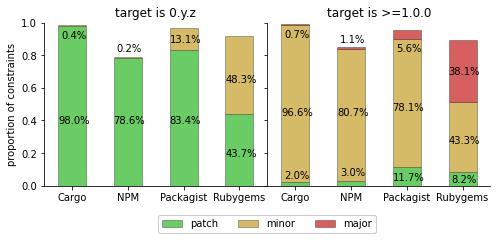

In [13]:
fig, axes = matplotlib.pyplot.subplots(
    ncols=2, 
    sharex=False, 
    sharey=True,
    gridspec_kw=dict(wspace=0)
)

for i, kind in enumerate(['0.y.z', '>=1.0.0']):
    (
        data
        .xs(kind, level=1)
        [['patch', 'minor', 'major']]
        .plot.bar(stacked=True, color=PAL_REL[0:3][::-1], linewidth=1, edgecolor=(0, 0, 0, 0.3), legend=False, ax=axes[i])
    )
    
    axes[i].set(
        title='target is {}'.format(kind),
        xlabel='', 
        ylabel=''
    )
    axes[i].xaxis.set_tick_params(rotation=0)

positions = [
    ((0.40, 0.92), (0.06, 0.45, 0.93)),
    ((0.40, 0.84), (0.08, 0.45, 0.90)),
    ((0.40, 0.90), (0.05, 0.48, 0.84)),
    ((0.20, 0.65), (0.04, 0.28, 0.70)),
]
for i, ecosystem in enumerate(ECOSYSTEMS):
    for j, kind in enumerate(['0.y.z', '>=1.0.0']):
        for k, release in enumerate(['patch', 'minor', 'major']):
            value = data.loc[ecosystem, kind][release]
            if kind == '0.y.z' and release == 'major':
                continue
            axes[j].annotate('{:.1%}'.format(value), (i + 0.03, positions[i][j][k]), ha='center', va='center')
    
axes[0].legend(
    loc='lower center',
    ncol=3,
    bbox_to_anchor=(1, -0.32),
)

seaborn.despine(fig, top=True, right=True)

axes[0].set(
    xlabel='',
    ylabel='proportion of constraints',
    ylim=(0, 1),
)

savefig(fig, 'need_permissiveness')

In [14]:
data.T

ecosystem     Cargo                 NPM           Packagist            \
kind        >=1.0.0     0.y.z   >=1.0.0     0.y.z   >=1.0.0     0.y.z   
major      0.006991  0.000000  0.010734  0.000000  0.056186  0.000000   
minor      0.965882  0.003598  0.806637  0.001829  0.780512  0.131409   
patch      0.019762  0.980396  0.030481  0.785587  0.116665  0.834203   

ecosystem  Rubygems            
kind        >=1.0.0     0.y.z  
major      0.380725  0.000000  
minor      0.432895  0.482676  
patch      0.081800  0.436878

As expected, most dependencies (except in Rubygems) are "compliant with semver". That means that, in a situation where they make use of the latest major release of a target package, they will automatically benefit from the latest patch (for 0.y.z) and minor releases (for >=1.0.0).

## Releases being used by dependent packages

However, we expect that not all dependents make use of the latest major of a target package. Let's quantify how many dependents make use of: the latest release, a previous patch, a previous minor or a previous major.

In [15]:
data = pandas.concat([
    df_dependents[ecosystem]
    [['source', 'target', 'selected']]
    # Get highest release of target package
    .merge(
        df_required[ecosystem]
        .drop_duplicates('package', keep='last')
        [['package', 'major', 'minor', 'patch']],
        how='inner',
        left_on='target',
        right_on='package',
    )
    # Get release for selected one
    .merge(
        df_required[ecosystem]
        [['package', 'rank', 'major', 'minor', 'patch']],
        how='inner',
        left_on=['target', 'selected'],
        right_on=['package', 'rank'],
        suffixes=(None, '_selected'),
    )
    .drop(columns=['package', 'package_selected', 'rank'])
    # Identify release being used
    .eval('''
        latest = major_selected == major and minor_selected == minor and patch_selected == patch
        previous_major = major_selected < major
        previous_minor = major_selected == major and minor_selected < minor
        previous_patch = major_selected == major and minor_selected == minor and patch_selected < patch
    ''')
    .assign(kind=lambda d: d[['latest', 'previous_major', 'previous_minor', 'previous_patch']].idxmax(axis=1))
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'source', 'target', 'kind']]
    for ecosystem in ECOSYSTEMS],
)

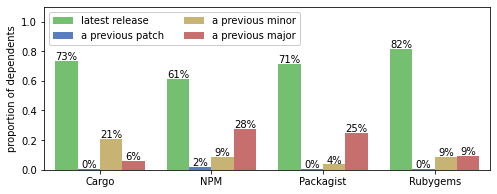

In [16]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    data
    .groupby(['ecosystem', 'kind'])
    .agg({'source': 'count'})
    .div(
        data
        .groupby('ecosystem')
        .agg({'source': 'count'})
    )
    .reset_index()
    .replace({'kind': {'latest': 'latest release', 'previous_major': 'a previous major', 'previous_minor': 'a previous minor', 'previous_patch': 'a previous patch'}})
)

seaborn.barplot(
    x='ecosystem',
    y='source',
    hue='kind',
    hue_order=['latest release', 'a previous patch', 'a previous minor', 'a previous major'],
    order=ECOSYSTEMS,
    data=temp,
    palette=np.take(PAL_REL, [2, 3, 1, 0], axis=0),
    ax=ax
)

for i, ecosystem in enumerate(ECOSYSTEMS):
    for j, label in enumerate(['latest release', 'a previous patch', 'a previous minor', 'a previous major']):
        value = temp[lambda d: (d['ecosystem'] == ecosystem) & (d['kind'] == label)].iloc[0].source
        x = i + (j * 0.2 - 0.30)
        ax.annotate('{:.0%}'.format(value), (x, value + 0.03), ha='center', va='center')

ax.legend(ncol=2, loc='upper left')

ax.set(
    xlabel='',
    ylabel='proportion of dependents',
    ylim=(0, 1.1),
)

savefig(fig, 'need_used_released')

In [17]:
(
    pandas.crosstab(data['ecosystem'], data['kind'], normalize='index', margins=True)
    .style.format('{:.1%}').background_gradient(vmin=0, vmax=1)
)

kind,latest,previous_major,previous_minor,previous_patch
ecosystem,,,,
Cargo,73.4%,5.7%,20.6%,0.3%
NPM,61.5%,27.7%,8.7%,2.0%
Packagist,71.4%,24.6%,3.6%,0.4%
Rubygems,81.8%,9.0%,8.7%,0.4%
All,63.1%,26.2%,8.9%,1.8%


## Induced technical lag

Relying on a previous version means that we "lag behind". We quantify this lag, in terms of time (difference between version used and latest version available) and in terms of versions (number of versions that were missed).

In [18]:
data = pandas.concat([
    df_dependents[ecosystem]
    [['source', 'target', 'selected']]
    # Get highest release of target package
    .merge(
        df_required[ecosystem]
        .drop_duplicates('package', keep='last')
        [['package', 'rank', 'date']],
        how='inner',
        left_on='target',
        right_on='package',
    )
    # Get release for selected one
    .merge(
        df_required[ecosystem]
        [['package', 'rank', 'date']],
        how='inner',
        left_on=['target', 'selected'],
        right_on=['package', 'rank'],
        suffixes=(None, '_selected'),
    )
    # Ignore up-to-date releases
    [lambda d: d['rank'] != d['selected']]
    .drop(columns=['package', 'package_selected'])
    .assign(timelag=lambda d: d['date'] - d['date_selected'])
    .assign(versionlag=lambda d: d['rank'] - d['selected'])
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'source', 'target', 'timelag', 'versionlag']]
    for ecosystem in ECOSYSTEMS],
)

### Time-lag

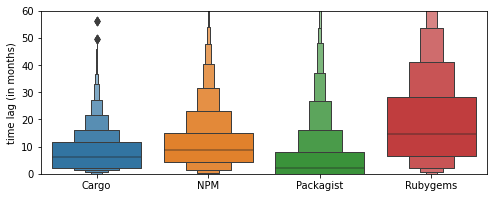

In [19]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='timelag',
    data=data.assign(timelag=lambda d: d['timelag'] / pandas.to_timedelta('30 day')),
    order=ECOSYSTEMS,
    palette=COLORS,
    ax=ax,
)

ax.set(
    xlabel='',
    ylabel='time lag (in months)',
    ylim=(0, 60),
)

savefig(fig, 'need_timelag')

In [20]:
(
    data
    .assign(timelag=lambda d: d['timelag'] / pandas.to_timedelta('30 day'))
    .groupby('ecosystem')
    .apply(lambda d: d['timelag'].describe())
)

timelag,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
Cargo,15516.0,7.554124,10.485656,-60.908777,2.129992,6.341589,11.583088,56.361447
NPM,383267.0,11.503991,11.548307,-81.491625,4.233987,8.857243,15.070653,103.785505
Packagist,24673.0,6.124878,11.317407,-44.487167,0.000983,2.062725,7.960320,101.691821
Rubygems,2570.0,19.309934,18.024859,-28.730652,6.534049,14.759125,28.337279,104.056190


### Version-lag

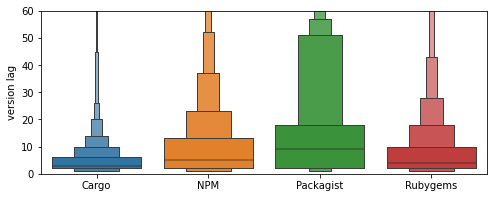

In [21]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='versionlag',
    data=data,
    order=ECOSYSTEMS,
    palette=COLORS,
    ax=ax,
)

ax.set(
    xlabel='',
    ylabel='version lag',
    ylim=(0, 60),
)

savefig(fig, 'need_versionlag')

In [22]:
(
    data
    .groupby('ecosystem')
    .apply(lambda d: d['versionlag'].describe())
)

versionlag,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
Cargo,15516.0,5.276940,8.341699,1.0,2.0,3.0,6.0,239.0
NPM,383267.0,11.708365,21.153103,1.0,2.0,5.0,13.0,1216.0
Packagist,24673.0,19.098164,34.333808,1.0,2.0,9.0,18.0,872.0
Rubygems,2570.0,11.475875,46.693701,1.0,2.0,4.0,10.0,907.0


## Number of major releases used by dependent packages

Since many dependents make use of a previous major release, let's quantify, given a required package, the number of distinct major being used by dependent packages.

In [23]:
data = pandas.concat([
    df_required[ecosystem]
    # Get the number of distinct major for each package
    .merge(
        df_required[ecosystem]
        .drop_duplicates(['package', 'major'])
        .groupby('package', as_index=False, sort=False)
        .agg({'major': 'count'})
        .rename(columns={'major': 'nb_major'}),
        how='left',
        on='package',
    )
    # Get the number of major used for each package. 
    .merge(
        df_required[ecosystem]
        [['package', 'rank', 'major']]
        .merge(
            df_dependents[ecosystem]
            [['target', 'selected']],
            how='right',
            left_on=['package', 'rank'],
            right_on=['target', 'selected'],
            suffixes=(None, '_selected'),
        )
        .drop(columns=['target', 'selected'])
        .drop_duplicates(['package', 'major'])
        .groupby('package', sort=False, as_index=False)
        .agg({'major': 'count'})
        .rename(columns={'major': 'used_major'})
    )
    [['package', 'nb_major', 'used_major']]
    .drop_duplicates()
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS],
)

### Number of available major releases

Let's first quantify the number of major releases that are available for each required package.

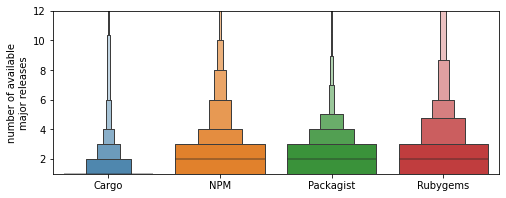

In [24]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='nb_major',
    data=data,
    order=ECOSYSTEMS,
    palette=COLORS,
    ax=ax
)

ax.set(
    xlabel='',
    ylabel='number of available\nmajor releases',
    ylim=(1, 12),
)

savefig(fig, 'need_number_major_available')

In [25]:
(
    data
    .groupby('ecosystem')
    .apply(lambda d: d['nb_major'].describe())
)

nb_major,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
Cargo,1181.0,2.947502,31.385827,1.0,1.0,1.0,1.0,637.0
NPM,15118.0,2.546898,2.643691,1.0,1.0,2.0,3.0,96.0
Packagist,2184.0,2.175824,1.581281,1.0,1.0,2.0,3.0,18.0
Rubygems,651.0,3.118280,5.476649,1.0,1.0,2.0,3.0,54.0


Or, using another way of showing things:

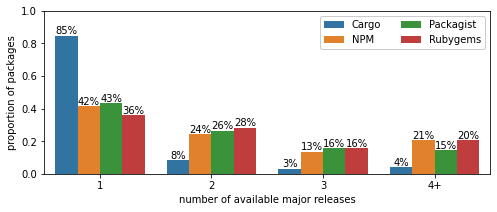

In [26]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    data
    .assign(nb_major=lambda d: d['nb_major'].where(d['nb_major'] < 4, '4+'))
    .groupby(['nb_major', 'ecosystem'])
    .agg({'package': 'count'})
    .pipe(lambda df:
        df.div(df.groupby('ecosystem').agg({'package': 'sum'}))
    )
    .reset_index()
)

seaborn.barplot(
    x='nb_major',
    y='package',
    hue='ecosystem',
    hue_order=ECOSYSTEMS,
    data=temp,
    palette=COLORS,
    ax=ax,
)

for i, ecosystem in enumerate(ECOSYSTEMS):
    for j, label in enumerate([1, 2, 3, '4+']):
        value = temp[lambda d: (d['ecosystem'] == ecosystem) & (d['nb_major'] == label)].iloc[0].package
        x = j + (i * 0.2 - 0.30)
        ax.annotate('{:.0%}'.format(value), (x, value + 0.03), ha='center', va='center')


ax.legend(title=None, ncol=2)

ax.set(
    xlabel='number of available major releases',
    ylabel='proportion of packages',
    ylim=(0, 1),
)

savefig(fig, 'need_number_major_available_barplot')

### Number of used major releases

Since from 35% to 85% (Cargo!) packages have only a single major version, we only consider packages having at least 2 major releases for the following analyses.

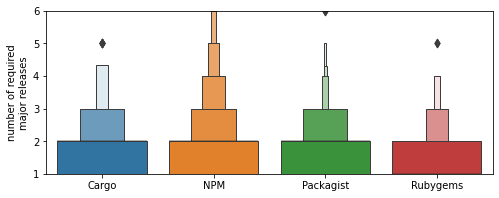

In [27]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='used_major',
    data=data[lambda d: d['nb_major'] > 1],
    palette=COLORS,
    order=ECOSYSTEMS,
    ax=ax
)

ax.set(
    xlabel='',
    ylabel='number of required\nmajor releases',
    ylim=(1, 6),
)

savefig(fig, 'need_number_used_major')

In [28]:
(
    data
    [lambda d: d['nb_major'] > 1]
    .groupby('ecosystem')
    .apply(lambda d: d['used_major'].describe())
)

used_major,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
Cargo,182.0,1.796703,0.984628,1.0,1.0,2.0,2.0,8.0
NPM,8832.0,2.023211,1.283601,1.0,1.0,2.0,2.0,30.0
Packagist,1240.0,1.725000,0.823987,1.0,1.0,2.0,2.0,7.0
Rubygems,418.0,1.614833,0.778900,1.0,1.0,1.0,2.0,5.0


Again, using a barplot:

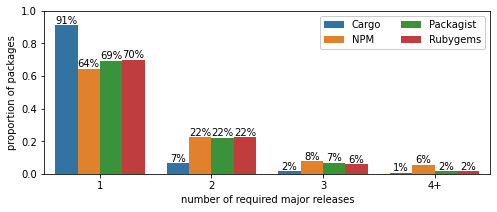

In [29]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    data
    .assign(used_major=lambda d: d['used_major'].where(d['used_major'] < 4, '4+'))
    .groupby(['used_major', 'ecosystem'])
    .agg({'package': 'count'})
    .pipe(lambda df:
        df.div(df.groupby('ecosystem').agg({'package': 'sum'}))
    )
    .reset_index()
)

seaborn.barplot(
    x='used_major',
    y='package',
    hue='ecosystem',
    hue_order=ECOSYSTEMS,
    data=temp,
    palette=COLORS,
    ax=ax,
)

for i, ecosystem in enumerate(ECOSYSTEMS):
    for j, label in enumerate([1, 2, 3, '4+']):
        value = temp[lambda d: (d['ecosystem'] == ecosystem) & (d['used_major'] == label)].iloc[0].package
        x = j + (i * 0.2 - 0.30)
        ax.annotate('{:.0%}'.format(value), (x, value + 0.03), ha='center', va='center')


ax.legend(title=None, ncol=2)

ax.set(
    xlabel='number of required major releases',
    ylabel='proportion of packages',
    ylim=(0, 1),
)

savefig(fig, 'need_number_used_major_barplot')

### Proportion of used major releases

Let's do the same, but proportionally to the total number of major releases available. 

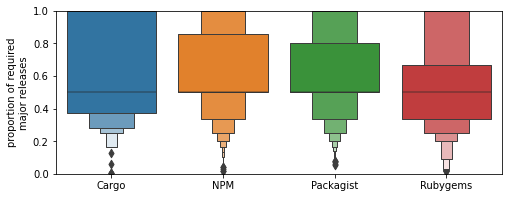

In [30]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='prop_major',
    order=ECOSYSTEMS,
    data=data[lambda d: d['nb_major'] > 1].eval('prop_major=used_major / nb_major'),
    palette=COLORS,
    ax=ax
)

ax.set(
    xlabel='',
    ylabel='proportion of required\nmajor releases',
    ylim=(0, 1),
)

savefig(fig, 'need_prop_major')

In [31]:
(
    data
    [lambda d: d['nb_major'] > 1]
    .eval('prop_major=used_major / nb_major')
    .groupby('ecosystem')
    .apply(lambda d: d['prop_major'].describe())
)

prop_major,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
Cargo,182.0,0.625628,0.297954,0.003140,0.375000,0.5,1.000000,1.0
NPM,8832.0,0.618504,0.258610,0.016393,0.500000,0.5,0.857143,1.0
Packagist,1240.0,0.611300,0.255812,0.055556,0.500000,0.5,0.800000,1.0
Rubygems,418.0,0.547036,0.266669,0.018519,0.333333,0.5,0.666667,1.0


## Package reuse index

Since a package can have many distinct releases being used by dependent packages, we could propose a "package reuse index" whose goal is to quantify the number of these releases. There are two options there:

1) A variant of a Gini-index, measuring the inequality in terms of "release usage". The more "inequal" this usage is, the more "focused" are dependent packages. However, this does not allow to show whether the "focus" is on the latest major or not. 

2) A variant of the H-index, where n means there are n releases each being used by n dependent packages. 

Let's first compute, for each available major, the number of dependent packages. We'll focus on packages with at least 2 major releases. 

In [32]:
data = pandas.concat([
    df_required[ecosystem]
    # Get dependents for each release
    .merge(
        df_dependents[ecosystem]
        [['source', 'target', 'selected']],
        how='left',
        left_on=['package', 'rank'],
        right_on=['target', 'selected']
    )
    # Group per major release, and count dependents
    .groupby(['package', 'major'], as_index=False)
    .agg({'source': 'count'})
    # Remove packages with a single major
    .groupby('package', as_index=False, sort=False)
    .filter(lambda g: len(g) > 1)
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
)

### Variant of Gini-index

Let's define a function to compute the Gini value of a numpy array. 

Taken from https://github.com/oliviaguest/gini

1 = inequality; 0 = equality.

In [33]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

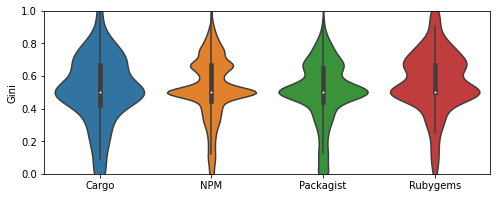

In [34]:
fix, ax = matplotlib.pyplot.subplots()

seaborn.violinplot(
    x='ecosystem',
    y='source',
    order=ECOSYSTEMS,
    data=(
        data
        .groupby(['ecosystem', 'package'], as_index=False)
        .agg({'source': lambda s: gini(s.to_numpy(dtype='float64'))})
    ),
    palette=COLORS,
    ax=ax
)

ax.set(
    xlabel='',
    ylabel='Gini',
    ylim=(0, 1),
)

savefig(fig, 'index_gini')

In [35]:
(
    data
    .groupby(['ecosystem', 'package'], as_index=False)
    .agg(gini=('source', lambda s: gini(s.to_numpy(dtype='float64'))))
    .groupby('ecosystem')
    .apply(lambda g: g.gini.describe())
)

gini,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
Cargo,182.0,0.511962,0.208636,0.0,0.421974,0.5,0.666667,0.998030
NPM,8870.0,0.524775,0.184988,0.0,0.447368,0.5,0.666667,0.983606
Packagist,1272.0,0.500166,0.190635,0.0,0.439195,0.5,0.650000,0.944444
Rubygems,418.0,0.563750,0.186790,0.0,0.500000,0.5,0.666667,0.981481


One can expect a relation between the number of dependents, available majors, required majors, and the Gini value...

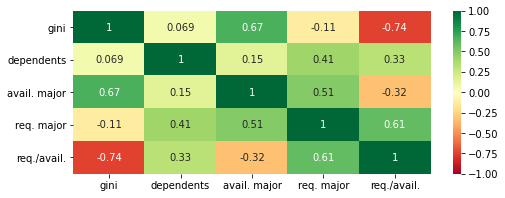

In [36]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.heatmap(
    data=(
        data
        .assign(used_major=lambda d: d['source'] > 0)
        .groupby(['ecosystem', 'package'], as_index=False)
        .agg(
            gini=('source', lambda s: gini(s.to_numpy(dtype='float64'))),
            dependents=('source', 'sum'),
            major=('major', 'count'),
            used_major=('used_major', 'sum')
        )
        .eval('ratio_major = used_major / major')
        [['gini', 'dependents', 'major', 'used_major', 'ratio_major']]
        .rename(columns={
            'gini': 'gini',
            'dependents': 'dependents',
            'major': 'avail. major',
            'used_major': 'req. major',
            'ratio_major': 'req./avail.'
        })
        .corr('spearman')
    ),
    vmin=-1,
    vmax=1,
    cmap='RdYlGn',
    annot=True,
    ax=ax,
)

savefig(fig, 'index_gini_corr')

### Variant of H-index

Let's first define a function that computes it.

In [37]:
def x_index(values):
    for i, d in enumerate(sorted(values, reverse=True)):
        if i + 1 >= d:
            #return max(d, 10e-5)
            return i + 1
    return i + 1

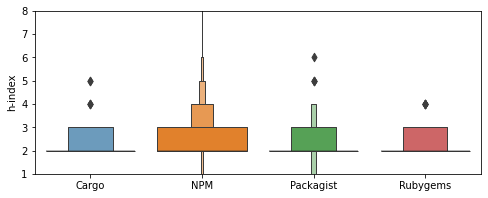

In [38]:
fix, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='source',
    order=ECOSYSTEMS,
    data=(
        data
        .groupby(['ecosystem', 'package'], as_index=False)
        .agg({'source': x_index})
    ),
    palette=COLORS,
    ax=ax
)

ax.set(
    xlabel='',
    ylabel='h-index',
    ylim=(1, 8),
)

savefig(fig, 'index_h')

In [39]:
(
    data
    .groupby(['ecosystem', 'package'], as_index=False)
    .agg({'source': x_index})
    .groupby('ecosystem').apply(lambda g: g.source.describe())
)

source,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
Cargo,182.0,2.197802,0.508921,2.0,2.0,2.0,2.0,5.0
NPM,8870.0,2.394814,0.823557,1.0,2.0,2.0,3.0,14.0
Packagist,1272.0,2.212264,0.542953,1.0,2.0,2.0,2.0,6.0
Rubygems,418.0,2.155502,0.394483,2.0,2.0,2.0,2.0,4.0


Is there any correlation with previously considered characteristics?

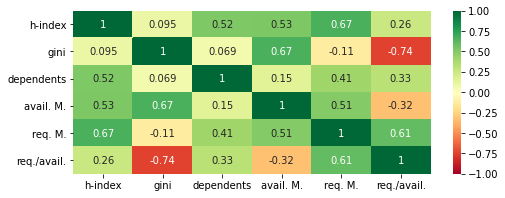

In [40]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.heatmap(
    data=(
        data
        .assign(used_major=lambda d: d['source'] > 0)
        .groupby(['ecosystem', 'package'], as_index=False)
        .agg(
            h_index=('source', x_index),
            gini=('source', lambda s: gini(s.to_numpy(dtype='float64'))),
            dependents=('source', 'sum'),
            major=('major', 'count'),
            used_major=('used_major', 'sum')
        )
        .eval('ratio_major = used_major / major')
        [['h_index', 'gini', 'dependents', 'major', 'used_major', 'ratio_major']]
        .rename(columns={
            'gini': 'gini',
            'dependents': 'dependents',
            'h_index': 'h-index',
            'major': 'avail. M.',
            'used_major': 'req. M.',
            'ratio_major': 'req./avail.'
        })
        .corr('spearman')
    ),
    vmin=-1,
    vmax=1,
    cmap='RdYlGn',
    annot=True,
    ax=ax,
)

savefig(fig, 'index_h_corr')

# On the prevalence of backported updates

## Evolution of the number of packages with backports

In [117]:
data = pandas.concat([
    df_required[ecosystem]
    .assign(
        pkg_first=lambda d: ~d['package'].duplicated(),
        backport_first=lambda d: ~d[['package', 'backported']].duplicated() & d['backported'],
        release=1,
        backports=lambda d: d['backported'].astype(int),
    )
    .set_index('date')
    [['pkg_first', 'backport_first', 'release', 'backports']]
    .sort_index()
    .cumsum()
    .assign(
        packages=lambda d: d['backport_first'] / d['pkg_first'],
        releases=lambda d: d['backports'] / d['release'],
    )
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
)

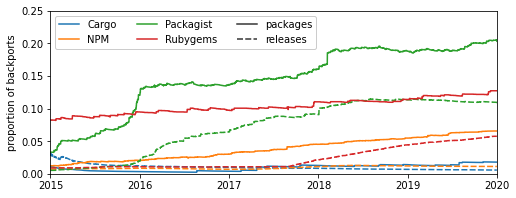

In [118]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.lineplot(
    x='date',
    y='value',
    hue='ecosystem',
    style='variable',
    data=pandas.melt(data, id_vars=['ecosystem', 'pkg_first', 'backport_first', 'release', 'backports'], value_vars=['packages', 'releases'], ignore_index=False),
    palette=COLORS,
    hue_order=ECOSYSTEMS,
    style_order=['packages', 'releases'],
    ci=None,  # speed-up
    ax=ax
)

handles, labels = ax.get_legend_handles_labels()
selection = list(range(1, len(ECOSYSTEMS) + 1)) + [-2, -1]
ax.legend(np.take(handles, selection), np.take(labels, selection), title=None, ncol=3)

ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='proportion of backports',
    ylim=(0, 0.25),
)

savefig(fig, 'prev_prop_packages_releases')

In [120]:
(
    data
    .groupby('ecosystem')
    .last()
)

,pkg_first,backport_first,release,backports,packages,releases
ecosystem,,,,,,
Cargo,1185,21,26185,149,0.017722,0.005690
NPM,15281,1010,570676,6425,0.066095,0.011259
Packagist,2247,457,100870,10886,0.203382,0.107921
Rubygems,652,83,35264,2036,0.127301,0.057736


### What happened to Rubygems in late 2017?

### What happened to Packagist in late 2015 & early 2018? 

## Proportion of backported releases for packages with backports

In [303]:
data = pandas.concat([
    df_required[ecosystem]
    .groupby('package', as_index=False, sort=False)
    .agg({
        'version': 'count',
        'backported': 'sum',
    })
    # Remove packages with no backport
    [lambda d: d['backported'] > 0]
    .assign(prop=lambda d: d['backported'] / d['version'])
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
)

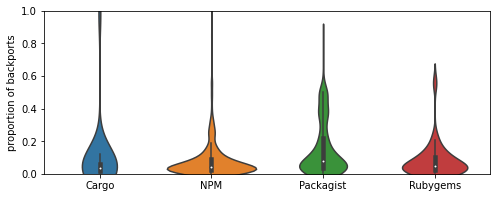

In [305]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.violinplot(
    x='ecosystem',
    y='prop',
    data=data,
    order=ECOSYSTEMS,
    palette=COLORS,
    ax=ax,
)

ax.set(
    xlabel='',
    ylabel='proportion of backports',
    ylim=(0, 1),
)

savefig(fig, 'prev_prop_releases')

In [46]:
(
    data
    .groupby('ecosystem')
    .apply(lambda g: g['prop'].describe())
)

prop,count,mean,std,min,25%,50%,75%,max
ecosystem,,,,,,,,
Cargo,21.0,0.089929,0.208263,0.004878,0.017544,0.035714,0.061224,0.983333
NPM,1010.0,0.082332,0.113916,0.000663,0.022185,0.044694,0.090909,0.955556
Packagist,457.0,0.154782,0.162862,0.003155,0.033113,0.081081,0.220339,0.825243
Rubygems,83.0,0.082513,0.108938,0.006024,0.021391,0.045045,0.100000,0.586592


## Proportion of major branches with backported releases

We count the number of major branches that have at least one backported release. 
Since packages with no backported releases won't have such major branches, we exclude them from the analysis. 
Also, notice that all packages (with backports) have at least one major branch without backported release (the last one), by definition. 

Consequently, if a package has `N>=2` major branches, it can have `[1, N-1]` majors with backports.

In [356]:
data = pandas.concat([
    df_required[ecosystem]
    # Keep only packages with backported releases
    .groupby('package', sort=False, as_index=False)
    .filter(lambda g: g['backported'].max())
    # Identify major branches
    .groupby(['package', 'major'], sort=False, as_index=False)
    .agg({'backported': 'max'})
    .groupby('package', sort=False, as_index=False)
    .agg({'major': 'count', 'backported': 'sum'})
    .assign(proportion=lambda d: d['backported'] / d['major'])
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
)

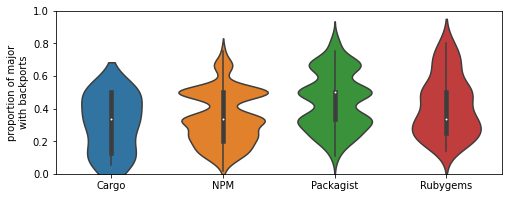

In [361]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.violinplot(
    x='ecosystem',
    y='proportion',
    data=data,
    palette=COLORS,
    ax=ax,
)

ax.set(
    xlabel='',
    ylabel='proportion of major\nwith backports',
    ylim=(0, 1), 
)

savefig(fig, 'prev_prop_major_with_backports')

In [365]:
(
    data
    .groupby('ecosystem')
    .apply(lambda g: g.describe())
)

major   backported   proportion
ecosystem                                             
Cargo     count    21.000000    21.000000    21.000000
          mean      5.523810     1.047619     0.307768
          std       4.728838     0.218218     0.169084
          min       2.000000     1.000000     0.055556
          25%       2.000000     1.000000     0.125000
          50%       3.000000     1.000000     0.333333
          75%       8.000000     1.000000     0.500000
          max      18.000000     2.000000     0.500000
NPM       count  1010.000000  1010.000000  1010.000000
          mean      4.622772     1.266337     0.345819
          std       4.572646     0.722946     0.160648
          min       2.000000     1.000000     0.015385
          25%       3.000000     1.000000     0.200000
          50%       4.000000     1.000000     0.333333
          75%       5.000000     1.000000     0.500000
          max      96.000000     8.000000     0.750000
Packagist count   457.000000   457.000000   457.000000
          mean      3.544858     1.481400     0.444409
          std       1.604086     0.797600     0.172980
          min       2.000000     1.000000     0.071429
          25%       3.000000     1.000000     0.333333
          50%       3.000000     1.000000     0.500000
          75%       4.000000     2.000000     0.500000
          max      14.000000     6.000000     0.833333
Rubygems  count    83.000000    83.000000    83.000000
          mean      4.024096     1.662651     0.417942
          std       1.886899     1.261794     0.182036
          min       2.000000     1.000000     0.142857
          25%       3.000000     1.000000     0.250000
          50%       4.000000     1.000000     0.333333
          75%       5.000000     2.000000     0.500000
          max      13.000000     8.000000     0.800000

Let's visualize the proportion of packages (regardless of the ecosystem) for each "case": 

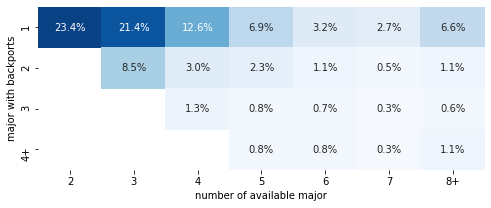

In [404]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.heatmap(
    data=(
        data
        .assign(
            major=lambda d: d['major'].where(d['major'] < 8, '8+'),
            backported=lambda d: d['backported'].where(d['backported'] < 4, '4+'),
        )
        .groupby(['major', 'backported'], as_index=False)
        .agg({'package': 'count'})
        .pivot(index='major', columns='backported', values='package')
        .div(len(data))
        .T
    ),
    vmin=0, 
    vmax=0.25, 
    annot=True,
    cmap='Blues',
    fmt='.1%',
    cbar=False,
    cbar_kws={'label': 'proportion of packages'},
    ax=ax
)

ax.set(
    xlabel='number of available major',
    ylabel='major with backports',
)

savefig(fig, 'prev_prop_major_with_backports_all')

## Relation between backports and dependents

We see whether there is relation between the presence of backports and the number of dependent packages.

In [47]:
data = pandas.concat([
    df_required[ecosystem]
    # Get dependents for each release
    .merge(
        df_dependents[ecosystem]
        [['source', 'target', 'selected']],
        how='left',
        left_on=['package', 'rank'],
        right_on=['target', 'selected']
    )
    # Group per major release, and count dependents
    .groupby(['package', 'major'], as_index=False)
    .agg({'source': 'count', 'backported': 'sum'})
    # For each package, get nb major, used major, dependents and backports
    .assign(used_major=lambda d: d['source'] > 0)
    .groupby('package', as_index=False, sort=False)
    .agg(
        major=('major', 'count'),
        used_major=('used_major', 'sum'),
        backports=('backported', 'sum')
    )
    .merge(
        df_dependents[ecosystem]
        .groupby('target', sort=False, as_index=False)
        .agg(dependents=('source', 'count')),
        how='left',
        left_on='package',
        right_on='target',
    )
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
)

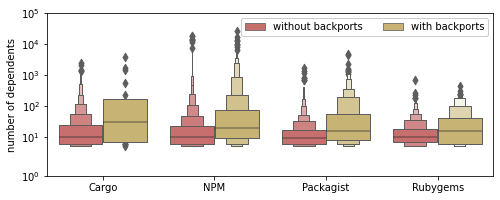

In [48]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='dependents',
    hue='backports',
    data=(
        data
        .assign(backports=lambda d: d['backports'] > 0)
        .replace({'backports': {True: 'with backports', False: 'without backports'}})
    ),
    order=ECOSYSTEMS,
    palette=PAL_REL,
    ax=ax,
)

ax.legend(title=None, ncol=2)

ax.set(
    xlabel='',
    ylabel='number of dependents',
    yscale='symlog',
    ylim=(1, 10e4),
)

savefig(fig, 'prev_backport_dependents')

In [49]:
(
    data
    .assign(backports=lambda d: d['backports'] > 0)
    .replace({'backports': {True: 'with backports', False: 'without backports'}})
    .groupby(['ecosystem', 'backports'])
    .apply(lambda g: g[['dependents']].describe())
    .unstack()
)

dependents                                     \
                                 count        mean          std  min  25%   
ecosystem backports                                                         
Cargo     with backports          21.0  383.571429   871.701587  5.0  7.0   
          without backports     1164.0   44.466495   157.653761  5.0  6.0   
NPM       with backports        1010.0  279.304950  1360.764012  5.0  9.0   
          without backports    14271.0   51.835541   373.278294  5.0  6.0   
Packagist with backports         457.0  108.234136   372.454995  5.0  8.0   
          without backports     1790.0   22.460335    73.742973  5.0  6.0   
Rubygems  with backports          83.0   45.783133    75.329204  5.0  6.0   
          without backports      569.0   19.799649    37.548962  5.0  7.0   

                                                    
                              50%     75%      max  
ecosystem backports                                 
Cargo     with backports     31.0  172.00   3647.0  
          without backports  10.0   24.00   2466.0  
NPM       with backports     20.0   72.00  26163.0  
          without backports  10.0   22.00  18354.0  
Packagist with backports     16.0   56.00   4844.0  
          without backports   9.0   16.75   1648.0  
Rubygems  with backports     15.0   41.00    420.0  
          without backports  10.0   18.00    664.0

Is there a statistical difference between these distributions?

In [50]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backports'] > 0)].dependents
    B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backports'] == 0)].dependents
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} with vs. without: p={:.5f}; d={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Cargo      with vs. without: p=0.00802; d=0.305 (small)
NPM        with vs. without: p=0.00000; d=0.311 (small)
Packagist  with vs. without: p=0.00000; d=0.328 (small)
Rubygems   with vs. without: p=0.00354; d=0.182 (small)


## Relation between backports and used major

We see whether there is a relation between the presence of backports and the number of major releases being used.

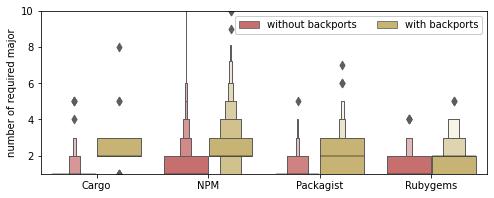

In [51]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='used_major',
    hue='backports',
    data=(
        data
        .assign(backports=lambda d: d['backports'] > 0)
        .replace({'backports': {True: 'with backports', False: 'without backports'}})
    ),
    order=ECOSYSTEMS,
    palette=PAL_REL,
    ax=ax,
)

ax.legend(title=None, ncol=2)

ax.set(
    xlabel='',
    ylabel='number of required major',
    ylim=(1, 10),
)

savefig(fig, 'prev_backport_used_major')

In [52]:
(
    data
    .assign(backports=lambda d: d['backports'] > 0)
    .replace({'backports': {True: 'with backports', False: 'without backports'}})
    .groupby(['ecosystem', 'backports'])
    .apply(lambda g: g[['used_major']].describe())
    .unstack()
)

used_major                                     \
                                 count      mean       std  min  25%  50%   
ecosystem backports                                                         
Cargo     with backports          21.0  2.523810  1.661898  1.0  2.0  2.0   
          without backports     1164.0  1.093643  0.394277  0.0  1.0  1.0   
NPM       with backports        1010.0  2.526733  1.630294  0.0  2.0  2.0   
          without backports    14271.0  1.513769  1.030612  0.0  1.0  1.0   
Packagist with backports         457.0  2.122538  0.947223  0.0  1.0  2.0   
          without backports     1790.0  1.180447  0.535344  0.0  1.0  1.0   
Rubygems  with backports          83.0  1.951807  1.010960  1.0  1.0  2.0   
          without backports      569.0  1.311072  0.590327  0.0  1.0  1.0   

                                        
                             75%   max  
ecosystem backports                     
Cargo     with backports     3.0   8.0  
          without backports  1.0   5.0  
NPM       with backports     3.0  15.0  
          without backports  2.0  30.0  
Packagist with backports     3.0   7.0  
          without backports  1.0   5.0  
Rubygems  with backports     2.0   5.0  
          without backports  2.0   4.0

In [53]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backports'] > 0)].used_major
    B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backports'] == 0)].used_major
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} with vs. without: p={:.5f}; d={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Cargo      with vs. without: p=0.00000; d=0.745 (large)
NPM        with vs. without: p=0.00000; d=0.471 (medium)
Packagist  with vs. without: p=0.00000; d=0.601 (large)
Rubygems   with vs. without: p=0.00000; d=0.382 (medium)


Can we suspect any other correlation? 

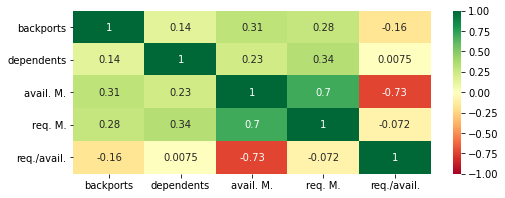

In [54]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.heatmap(
    data=(
        data
        [['backports', 'dependents', 'major', 'used_major']]
        .eval('ratio_major = used_major / major')
        .rename(columns={
            'major': 'avail. M.',
            'used_major': 'req. M.',
            'ratio_major': 'req./avail.'
        })
        .corr('spearman')
    ),
    vmin=-1,
    vmax=1,
    cmap='RdYlGn',
    annot=True,
    ax=ax,
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

savefig(fig, 'prev_correlation')

## Dependent packages relying on backported releases

Dependent packages could benefit from backports if they allow such updates through dependency constraints. 
For this analysis, we look at all major branches that have backports, and we identify dependent packages that benefit from such backports. 

In [326]:
data = pandas.concat([
    df_dependents[ecosystem]
    .drop(columns=['rank'])
    .merge(
        df_required[ecosystem]
        [['package', 'major', 'rank', 'backported']],
        how='inner',
        left_on=['target', 'selected'],
        right_on=['package', 'rank'],
    )
    # Identify major branches that have a backport
    .merge(
        df_required[ecosystem]
        .groupby(['package', 'major'], as_index=False, sort=False)
        .agg(
            backport=('backported', 'max'),
            first_rank=('rank', 'min'),
            last_rank=('rank', 'max'),
        ),
        how='inner',
        left_on=['package', 'major'],
        right_on=['package', 'major'],
    )
    # Keep only major that have backports
    [lambda d: d['backport']]
    [['source', 'target', 'selected', 'major', 'rank', 'backported', 'first_rank', 'last_rank']]
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
)

In [351]:
(
    data
    .groupby(['ecosystem'], as_index=False, sort=False)
    .agg(
        dependents=('source', 'count'),
        backported=('backported', 'sum'),
    )
    .assign(proportion=lambda d: d['backported'] / d['dependents'])
    .style
    .format({'proportion': '{:.1%}'})
    .bar(subset=['proportion'], vmin=0, vmax=1, color='lightblue')
)

,ecosystem,dependents,backported,proportion
0,Cargo,386,372,96.4%
1,NPM,53015,44450,83.8%
2,Packagist,14737,13705,93.0%
3,Rubygems,310,254,81.9%


This shows that most packages depending on a major branch that has backported releases actually depend on such backported releases. 

# How and when are releases backported?

## Backport release type

The type of a backport depends on the "source" release (the one being backported) and the "target" release (the one being the backport). We expect that most backports correspond to patches being backported as patches, but it could be the case that some minor release has its fixes being backported as patch as well.

In [55]:
data = pandas.concat([
    df_required[ecosystem]
    .merge(
        df_required[ecosystem].drop(columns=['backported', 'backported_from']),
        how='inner',
        left_on=['package', 'backported_from'],
        right_on=['package', 'rank'],
        suffixes=(None, '_from'),
    )
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
)

In [56]:
(
    data
    .groupby(['ecosystem', 'kind_from', 'kind'])
    .agg({'package': 'count'})
    .div(
        data
        .groupby('ecosystem')
        .agg({'package': 'count'})
    )
    .unstack()
    .merge(
        data
        .groupby(['ecosystem', 'kind_from', 'kind'])
        .agg({'package': 'count'})
        .unstack(),
        left_index=True,
        right_index=True,
        suffixes=('_prop', None)
    )
    .style
    .format('{:.1%}', subset='package_prop')
    .background_gradient(subset='package_prop', vmin=0, vmax=1, axis=None)
    .background_gradient(subset='package', axis=None)
)

Or, all package distributions combined:

In [57]:
(
    data
    .groupby(['kind_from', 'kind'])
    .agg({'package': 'count'})
    .div(len(data))
    .unstack()
    .style
    .format('{:.1%}', subset='package')
    .background_gradient(subset='package', vmin=0, vmax=1, axis=None)
)

## Time to backport a release since a major

We expect that most backports are "quickly" released when a new major is available, in order to allow security or stability fixes to be available for dependents during their transition to the new major. 

Here, we assume that a "branch" (i.e. a major) is expected to be "abandonned" as soon as the next major is releases. Hence, we compute the time between the release date of the next major release and the release date of the backport. This merely corresponds to the question "How long does it take to release in a previous major-branch?".

More formally, for each major `N.0.0`, if there is a backport `(N-1).y.z`, we compute the time between `N.0.0` and `(N-1).y.z`.

In [250]:
data = pandas.concat([
    df_required[ecosystem]
    [lambda d: d['backported']]
    [['package', 'version', 'major', 'rank', 'rank_date', 'date']]
    .assign(next_major=lambda d: d['major'] + 1)
    # Get major release date
    .merge(
        df_required[ecosystem]
        [lambda d: d['kind'] == 'major']
        [['package', 'major', 'rank', 'rank_date', 'date']],
        how='inner',
        left_on=['package', 'next_major'],
        right_on=['package', 'major'],
        suffixes=(None, '_next_major'),
    )
    .drop(columns=['next_major'])
    .sort_values('rank_date')
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
)

Since it could be the case that some update is backported years after (e.g. for security reason), or that many consecutive updates are backported in a row (hence, increasing the impact of a single package), we only consider the first backported version for each major release. 

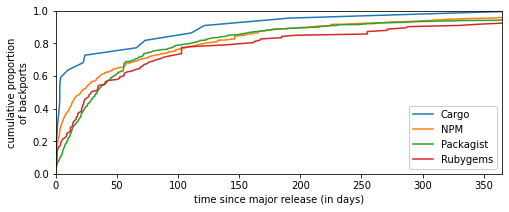

In [200]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.lineplot(
    x='time',
    y='cases',
    hue='ecosystem',
    data=(
        data
        .drop_duplicates(['ecosystem', 'package', 'major'], keep='first')
        .assign(time=lambda d: (d['date'] - d['date_next_major']) / pandas.to_timedelta('1 day'))
        .assign(cases=1)
        .sort_values('time')
        .groupby('ecosystem', sort=False)
        .apply(lambda g: g.assign(cases=lambda d: d['cases'].cumsum() / len(d)))
    ),
    palette=COLORS,
    hue_order=ECOSYSTEMS,
    ci=None,  # speed-up
    ax=ax
)

ax.legend(title=None)

ax.set(
    xlabel='time since major release (in days)',
    xlim=(0, 365),
    ylabel='cumulative proportion\nof backports',
    ylim=(0, 1),
)

savefig(fig, 'time_since_next_major')

In [206]:
(
    data
    .drop_duplicates(['ecosystem', 'package', 'major'], keep='first')
    .assign(time=lambda d: (d['date'] - d['date_next_major']) / pandas.to_timedelta('1 day'))
    .assign(cases=1)
    .sort_values('time')
    .groupby('ecosystem', sort=False, as_index=False)
    .apply(lambda g: g.assign(cases=lambda d: d['cases'].cumsum() / len(d)))
    [lambda d: d['cases'] >= 0.5]
    [['ecosystem', 'time', 'cases']]
    .groupby('ecosystem').first()
)

,time,cases
ecosystem,,
Cargo,3.343634,0.500000
NPM,20.848437,0.500418
Packagist,34.137431,0.500000
Rubygems,29.322720,0.503759


Let's compare the time required to backport the first and the last update. 

In [251]:
temp = (
    data
    .groupby(['ecosystem', 'package', 'major'], sort=False, as_index=False)
    .agg(
        date_next_major=('date_next_major', 'first'),
        date_first=('date', 'first'),
        date_last=('date', 'last'),
    )
    .pipe(lambda df: 
        pandas.melt(df, id_vars=['ecosystem', 'package', 'major', 'date_next_major'], value_vars=['date_first', 'date_last'])
    )
    .assign(time=lambda d: (d['value'] - d['date_next_major']) / pandas.to_timedelta('30 day'))
    .replace({'variable': {'date_first': 'first', 'date_last': 'last'}})
)

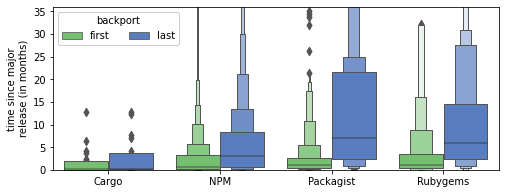

In [252]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='time',
    hue='variable',
    data=temp,
    order=ECOSYSTEMS,
    palette=np.take(PAL_REL, [2, 3], axis=0),
    ax=ax,
)

ax.legend(title='backport', ncol=2)

ax.set(
    xlabel='',
    ylabel='time since major\nrelease (in months)',
    ylim=(0, 36),
)

savefig(fig, 'time_since_next_major_boxenplot')

In [198]:
(
    temp
    .groupby(['ecosystem', 'variable'])
    .apply(lambda d: d['time'].describe())
)

time                 count       mean        std           min       25%  \
ecosystem variable                                                         
Cargo     first       22.0   1.562898   3.043591  2.642207e-02  0.046200   
          last        22.0   5.099231  13.075710  2.642207e-02  0.071299   
NPM       first     1197.0   2.646589   5.047616  7.716049e-07  0.110378   
          last      1197.0   6.160214   8.781081  7.716049e-07  0.667653   
Packagist first      664.0   2.927808   4.793716  3.472222e-06  0.450501   
          last       664.0  12.051916  11.852815  7.986111e-05  2.412889   
Rubygems  first      133.0   4.832190  10.391092  1.412037e-04  0.401351   
          last       133.0  10.898102  12.694889  1.412037e-04  2.173804   

time                     50%        75%        max  
ecosystem variable                                  
Cargo     first     0.111469   1.848293  12.869686  
          last      0.260965   3.644902  60.908777  
NPM       first     0.695296   3.257698  45.698297  
          last      2.961916   8.371018  81.491625  
Packagist first     1.313886   2.876138  35.087022  
          last      7.049029  21.446370  53.921062  
Rubygems  first     1.154552   3.430251  63.138760  
          last      5.673777  14.356684  63.138760

## Extended support for major with backports

One can expect that major releases receiving backported updates are supported longer than the ones that do not receive backports.

By "support", we mean the time between the very first and very last release of a major branch.

In [293]:
data = pandas.concat([
    df_required[ecosystem]
    .groupby(['package', 'major'], sort=False, as_index=False)
    .agg(
        backport=('backported', 'max'),
        date_first=('date', 'first'),
        date_last=('date', 'last'),
        rank_first=('rank', 'first'),
        rank_last=('rank', 'last'),
    )
    .assign(time=lambda d: (d['date_last'] - d['date_first']) / pandas.to_timedelta('365 day'))
    .assign(versions=lambda d: d['rank_last'] - d['rank_first'] + 1)
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS],
)

### In terms of time

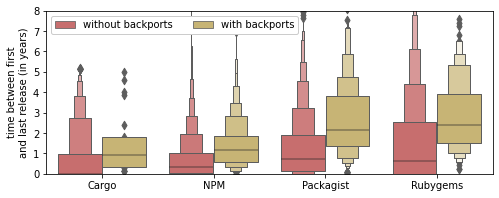

In [275]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='time',
    hue='backport',
    data=(
        data
        .replace({'backport': {True: 'with backports', False: 'without backports'}})
    ),
    order=ECOSYSTEMS,
    palette=PAL_REL,
    ax=ax,
)

ax.legend(title=None, ncol=2, loc='upper left')

ax.set(
    xlabel='',
    ylabel='time between first\nand last release (in years)',
    ylim=(0, 8),
)

savefig(fig, 'support_time')

In [276]:
(
    data
    .groupby(['ecosystem', 'backport'])
    .apply(lambda d: d['time'].describe())
)

time                  count      mean       std       min       25%       50%  \
ecosystem backport                                                              
Cargo     False      3463.0  0.774224  1.358217  0.000000  0.000000  0.000000   
          True         22.0  1.476719  1.537203  0.153219  0.331021  0.931016   
NPM       False     37453.0  0.784854  1.122460  0.000000  0.033984  0.345913   
          True       1279.0  1.443283  1.184539  0.000008  0.592135  1.188312   
Packagist False      4186.0  1.328627  1.604758  0.000000  0.129207  0.723021   
          True        677.0  2.669348  1.778910  0.012523  1.356370  2.146652   
Rubygems  False      1893.0  1.680273  2.247704  0.000000  0.003541  0.619006   
          True        138.0  2.895753  1.745500  0.241110  1.515117  2.401423   

time                     75%        max  
ecosystem backport                       
Cargo     False     0.995757   5.166968  
          True      1.798380   5.007385  
NPM       False     1.043064   8.848013  
          True      1.841562   7.484571  
Packagist False     1.900434  13.203131  
          True      3.837941   8.358179  
Rubygems  False     2.550195  10.470767  
          True      3.892485   7.615876

In [277]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & d['backport']].time
    B = data[lambda d: (d['ecosystem'] == ecosystem) & ~d['backport']].time
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} with vs. without: p={:.5f}; d={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Cargo      with vs. without: p=0.00000; d=0.530 (large)
NPM        with vs. without: p=0.00000; d=0.464 (medium)
Packagist  with vs. without: p=0.00000; d=0.515 (large)
Rubygems   with vs. without: p=0.00000; d=0.475 (large)


Since it could be unfair to compare packages having backports with packages having no backport, let's restrict the set of considered packages to the ones that have at least one time backported a release. 

In [278]:
temp = (
    data
    .groupby(['ecosystem', 'package'], sort=False)
    .filter(lambda g: g['backport'].max())
)

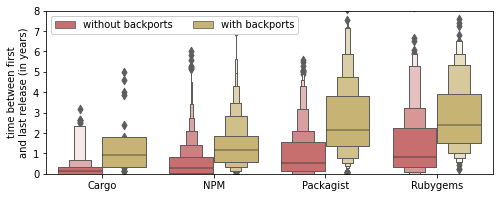

In [279]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='time',
    hue='backport',
    data=(
        temp
        .replace({'backport': {True: 'with backports', False: 'without backports'}})
    ),
    order=ECOSYSTEMS,
    palette=PAL_REL,
    ax=ax,
)

ax.legend(title=None, ncol=2, loc='upper left')

ax.set(
    xlabel='',
    ylabel='time between first\nand last release (in years)',
    ylim=(0, 8),
)

savefig(fig, 'support_time_restricted')

In [280]:
(
    temp
    .groupby(['ecosystem', 'backport'])
    .apply(lambda d: d['time'].describe())
)

time                 count      mean       std       min       25%       50%  \
ecosystem backport                                                             
Cargo     False       94.0  0.367585  0.703296  0.000000  0.000000  0.119035   
          True        22.0  1.476719  1.537203  0.153219  0.331021  0.931016   
NPM       False     3390.0  0.584642  0.810019  0.000000  0.037501  0.277558   
          True      1279.0  1.443283  1.184539  0.000008  0.592135  1.188312   
Packagist False      943.0  0.992704  1.148907  0.000000  0.129189  0.536549   
          True       677.0  2.669348  1.778910  0.012523  1.356370  2.146652   
Rubygems  False      196.0  1.530775  1.780831  0.000000  0.326066  0.826220   
          True       138.0  2.895753  1.745500  0.241110  1.515117  2.401423   

time                     75%        max  
ecosystem backport                       
Cargo     False     0.334722   3.186100  
          True      1.798380   5.007385  
NPM       False     0.799609   6.033606  
          True      1.841562   7.484571  
Packagist False     1.575652   5.575172  
          True      3.837941   8.358179  
Rubygems  False     2.252801  10.470767  
          True      3.892485   7.615876

In [281]:
for ecosystem in ECOSYSTEMS:
    A = temp[lambda d: (d['ecosystem'] == ecosystem) & d['backport']].time
    B = temp[lambda d: (d['ecosystem'] == ecosystem) & ~d['backport']].time
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} with vs. without: p={:.5f}; d={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Cargo      with vs. without: p=0.00000; d=0.684 (large)
NPM        with vs. without: p=0.00000; d=0.564 (large)
Packagist  with vs. without: p=0.00000; d=0.629 (large)
Rubygems   with vs. without: p=0.00000; d=0.519 (large)


### In terms of versions

We only consider packages with backports for the above reasons. 

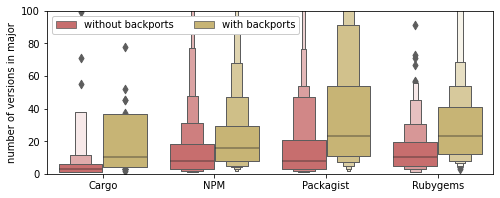

In [286]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='versions',
    hue='backport',
    data=(
        temp
        .replace({'backport': {True: 'with backports', False: 'without backports'}})
    ),
    order=ECOSYSTEMS,
    palette=PAL_REL,
    ax=ax,
)

ax.legend(title=None, ncol=2, loc='upper left')

ax.set(
    xlabel='',
    ylabel='number of versions in major',
    ylim=(0, 100),
)

savefig(fig, 'support_versions')

In [283]:
(
    temp
    .groupby(['ecosystem', 'backport'])
    .apply(lambda d: d['versions'].describe())
)

versions             count       mean         std  min   25%   50%    75%  \
ecosystem backport                                                          
Cargo     False       94.0   9.861702   22.216240  1.0   1.0   3.0   6.00   
          True        22.0  24.272727   29.801217  2.0   4.0  10.0  36.50   
NPM       False     3390.0  17.059882   78.199676  1.0   3.0   8.0  18.00   
          True      1279.0  27.708366   59.169607  2.0   8.0  16.0  29.50   
Packagist False      943.0  18.318134   35.655800  1.0   3.0   8.0  21.00   
          True       677.0  46.345643   73.755745  2.0  11.0  23.0  54.00   
Rubygems  False      196.0  15.678571   17.054175  1.0   5.0  10.0  19.25   
          True       138.0  46.181159  119.320597  3.0  12.0  23.0  41.00   

versions               max  
ecosystem backport          
Cargo     False      105.0  
          True       119.0  
NPM       False     4280.0  
          True      1345.0  
Packagist False      795.0  
          True      1338.0  
Rubygems  False      123.0  
          True       844.0

In [284]:
for ecosystem in ECOSYSTEMS:
    A = temp[lambda d: (d['ecosystem'] == ecosystem) & d['backport']].versions
    B = temp[lambda d: (d['ecosystem'] == ecosystem) & ~d['backport']].versions
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} with vs. without: p={:.5f}; d={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Cargo      with vs. without: p=0.00005; d=0.528 (large)
NPM        with vs. without: p=0.00000; d=0.369 (medium)
Packagist  with vs. without: p=0.00000; d=0.478 (large)
Rubygems   with vs. without: p=0.00000; d=0.470 (medium)
